In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# # For Sentiment Analysis
import nltk
nltk.download('vader_lexicon') # Ensure VADER lexicon is downloaded

from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/matania/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



 --- 1. Load News Data ---

In [8]:

try:
    news_df_orig = pd.read_csv('../data/raw/financial_news.csv') # Load original for fresh processing
except FileNotFoundError:
    print("Error: financial_news.csv not found. Using DUMMY data.")
    _data = {
        'headline': [
            "Apple hits new all-time high after strong earnings", "Stock up!",
            "Tesla stock drops on production concerns", "Very bad news for TSLA",
            "Microsoft announces new AI partnership, stock jumps",
            "Google parent Alphabet misses Q3 revenue targets",
            "Generic good news for AAPL", "Generic bad news for MSFT"
        ],
        'date': [ # Ensure these dates make sense for stock data fetching
            "2023-10-26 09:30:00-04:00", "2023-10-26 10:00:00-04:00",
            "2023-10-26 10:15:00-04:00", "2023-10-26 11:00:00-04:00",
            "2023-10-27 11:00:00-04:00",
            "2023-10-27 14:00:00-04:00",
            "2023-10-28 08:00:00-04:00", "2023-10-28 09:00:00-04:00"
        ],
        'stock': ["AAPL", "AAPL", "TSLA", "TSLA", "MSFT", "GOOGL", "AAPL", "MSFT"]
    }
    news_df_orig = pd.DataFrame(_data)

news_df = news_df_orig.copy()
news_df['headline'] = news_df['headline'].astype(str)


In [9]:

# --- 2. Data Preparation: Normalize Dates ---
# Convert news date to datetime objects and then to date (day level)
# Pandas to_datetime handles the UTC-4 offset automatically.
news_df['datetime_utc-4'] = pd.to_datetime(news_df['date'], errors='coerce')
news_df.dropna(subset=['datetime_utc-4'], inplace=True) # Drop if conversion failed

# We need to decide how to map news time to stock market day.
# News can come out before market open, during, or after close.
# Simplest approach: news on day D relates to stock movement from D to D+1 (or D's close).
# Let's extract the date part. Stock data is usually indexed by date (representing market open/close for that day).
news_df['publish_date'] = news_df['datetime_utc-4'].dt.normalize() # Normalize to midnight
                                                               # .dt.date would give date objects, normalize() keeps it datetime
# print("News data with publish_date:")
# print(news_df[['stock', 'headline', 'publish_date']].head())



News Data with Sentiment Scores (VADER Compound):
  stock                                           headline  \
0     A            Stocks That Hit 52-Week Highs On Friday   
1     A         Stocks That Hit 52-Week Highs On Wednesday   
2     A                      71 Biggest Movers From Friday   
3     A       46 Stocks Moving In Friday's Mid-Day Session   
4     A  B of A Securities Maintains Neutral on Agilent...   

               publish_date  sentiment_vader  
0 2020-06-05 00:00:00-04:00            0.000  
1 2020-06-03 00:00:00-04:00            0.000  
2 2020-05-26 00:00:00-04:00            0.000  
3 2020-05-22 00:00:00-04:00            0.000  
4 2020-05-22 00:00:00-04:00            0.296  


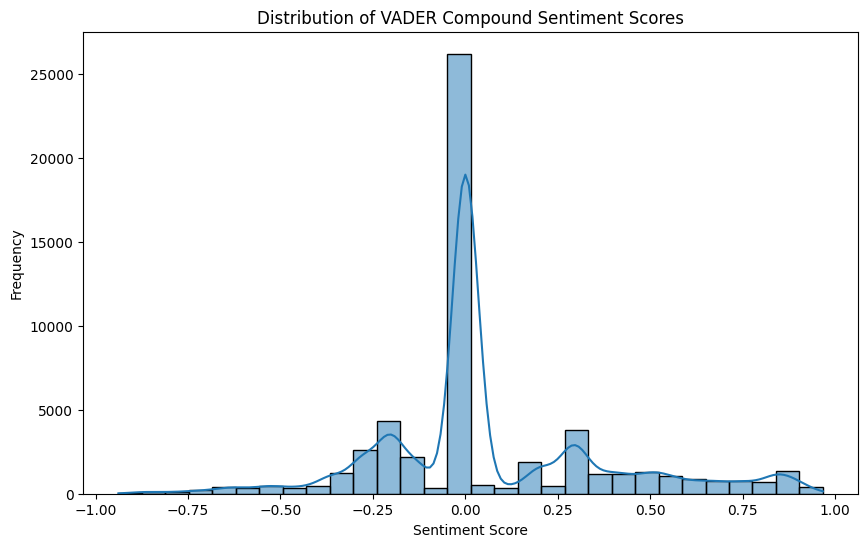

In [10]:

# --- 3. Perform Sentiment Analysis ---
analyzer = SentimentIntensityAnalyzer()
news_df['sentiment_vader'] = news_df['headline'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

print("\nNews Data with Sentiment Scores (VADER Compound):")
print(news_df[['stock', 'headline', 'publish_date', 'sentiment_vader']].head())

plt.figure(figsize=(10, 6))
sns.histplot(news_df['sentiment_vader'], bins=30, kde=True)
plt.title('Distribution of VADER Compound Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

In [11]:

# --- 4. Aggregate Sentiments per Stock per Day ---
# If multiple articles for the same stock on the same day, average their sentiment.
# Group by stock symbol and publish_date, then calculate mean sentiment
daily_sentiment = news_df.groupby(['stock', 'publish_date'])['sentiment_vader'].mean().reset_index()
daily_sentiment.rename(columns={'sentiment_vader': 'avg_daily_sentiment'}, inplace=True)

print("\nAverage Daily Sentiment per Stock:")
print(daily_sentiment.head())


Average Daily Sentiment per Stock:
  stock              publish_date  avg_daily_sentiment
0     A 2020-05-22 00:00:00-04:00               0.0480
1     A 2020-05-26 00:00:00-04:00               0.0000
2     A 2020-06-03 00:00:00-04:00               0.0000
3     A 2020-06-05 00:00:00-04:00               0.0000
4    AA 2020-05-18 00:00:00-04:00               0.8519


In [ ]:

# --- 5. Load Stock Price Data and Calculate Daily Returns ---
unique_tickers_sentiment = daily_sentiment['stock'].unique()
if daily_sentiment.empty:
    print("No daily sentiment data to process. Exiting stock data part.")
    stock_returns_df = pd.DataFrame() # Empty df
else:
    min_news_date = daily_sentiment['publish_date'].min()
    max_news_date = daily_sentiment['publish_date'].max()

    # Fetch stock data for a slightly wider range to calculate returns
    # yfinance dates are exclusive for end_date in terms of data rows, inclusive for start_date.
    # We need data for one day after max_news_date to calculate return for max_news_date.
    start_fetch_date = (min_news_date - pd.DateOffset(days=5)).strftime('%Y-%m-%d') # Few days before for safety
    end_fetch_date = (max_news_date + pd.DateOffset(days=5)).strftime('%Y-%m-%d')   # Few days after for safety

    print(f"\nFetching stock data for tickers: {unique_tickers_sentiment} from {start_fetch_date} to {end_fetch_date}")

    all_stock_data = {}
    for ticker in unique_tickers_sentiment:
        try:
            # Fetching daily data
            data = yf.download(ticker, start=start_fetch_date, end=end_fetch_date, progress=False)
            if not data.empty:
                # Calculate daily returns: (Close_t - Close_{t-1}) / Close_{t-1}
                data['daily_return'] = data['Close'].pct_change()
                # Shift sentiment or returns?
                # If news on Day D affects stock on Day D (using Close price of Day D vs Day D-1):
                #   No shift needed for merging, but the return for Day D is based on Close_D vs Close_{D-1}
                # If news on Day D affects stock on Day D+1 (Open_D+1 vs Close_D):
                #   This is more complex as it requires aligning based on next day's open.
                # Simplest for now: Correlate sentiment on Day D with return calculated AT Day D's close.
                all_stock_data[ticker] = data[['daily_return']].copy() # Only keep returns and index (Date)
                all_stock_data[ticker].index = pd.to_datetime(all_stock_data[ticker].index).normalize() # Ensure Date is normalized
            else:
                print(f"No stock data found for {ticker}")
        except Exception as e:
            print(f"Could not fetch stock data for {ticker}: {e}")

    if not all_stock_data:
        print("No stock data could be fetched. Cannot proceed with correlation.")
        stock_returns_df = pd.DataFrame()
    else:
        # Combine all stock returns into a single DataFrame for easier merging
        # This step might need adjustment if you want to keep them separate
        stock_returns_list = []
        for ticker, df_ret in all_stock_data.items():
            df_ret_copy = df_ret.copy() # Avoid SettingWithCopyWarning
            df_ret_copy['stock'] = ticker
            stock_returns_list.append(df_ret_copy.reset_index()) # Date becomes a column

        if not stock_returns_list:
            print("No valid stock returns data. Cannot proceed.")
            stock_returns_df = pd.DataFrame()
        else:
            stock_returns_df = pd.concat(stock_returns_list)
            stock_returns_df.rename(columns={'Date': 'stock_date'}, inplace=True) # Rename Date column
            print("\nStock Returns Data (sample):")
            print(stock_returns_df.head())


Fetching stock data for tickers: ['A' 'AA' 'AAC' ... 'ZU' 'ZUMZ' 'ZX'] from 2011-04-22 to 2020-06-16



1 Failed download:
['AAC']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AAC



1 Failed download:
['AADR']: Timeout('Failed to perform, curl: (28) Operation timed out after 10000 milliseconds with 49655 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


No stock data found for AADR


Failed to get ticker 'AAMC' reason: Failed to perform, curl: (28) Connection timed out after 10001 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.

1 Failed download:
['AAMC']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AAMC



1 Failed download:
['AAN']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AAN



1 Failed download:
['AAU']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AAU



1 Failed download:
['AAV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for AAV



1 Failed download:
['AAWW']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AAWW



1 Failed download:
['ABAC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ABAC



1 Failed download:
['ABAX']: ValueError('Length mismatch: Expected axis has 2 elements, new values have 1 elements')


No stock data found for ABAX



1 Failed download:
['ABB']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ABB



1 Failed download:
['ABC']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ABC



1 Failed download:
['ABCO']: Timeout('Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


No stock data found for ABCO



1 Failed download:
['ABCW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ABCW



1 Failed download:
['ABDC']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ABDC



1 Failed download:
['ABGB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ABGB



1 Failed download:
['ABIO']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ABIO


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/matania/nltk_data...



News Data with Sentiment Scores (VADER Compound):
  stock                                           headline  \
0     A            Stocks That Hit 52-Week Highs On Friday   
1     A         Stocks That Hit 52-Week Highs On Wednesday   
2     A                      71 Biggest Movers From Friday   
3     A       46 Stocks Moving In Friday's Mid-Day Session   
4     A  B of A Securities Maintains Neutral on Agilent...   

               publish_date  sentiment_vader  
0 2020-06-05 00:00:00-04:00            0.000  
1 2020-06-03 00:00:00-04:00            0.000  
2 2020-05-26 00:00:00-04:00            0.000  
3 2020-05-22 00:00:00-04:00            0.000  
4 2020-05-22 00:00:00-04:00            0.296  


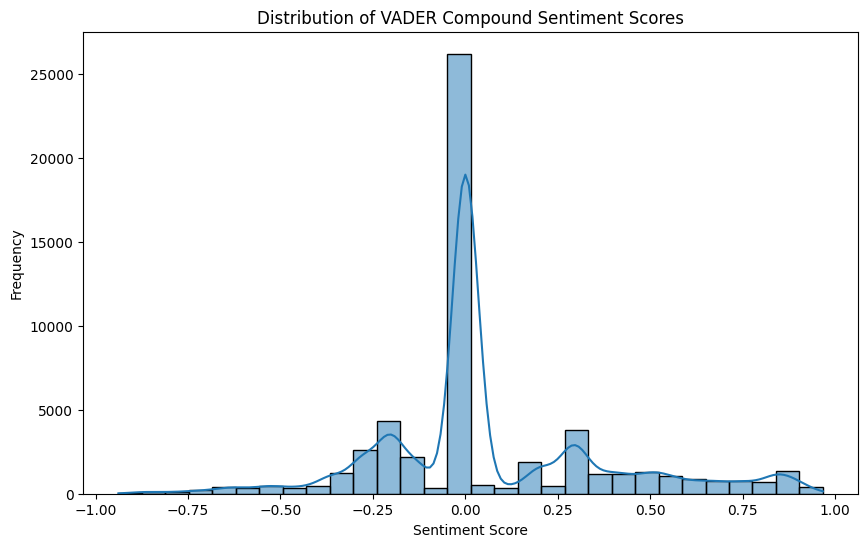


Average Daily Sentiment per Stock:
  stock              publish_date  avg_daily_sentiment
0     A 2020-05-22 00:00:00-04:00               0.0480
1     A 2020-05-26 00:00:00-04:00               0.0000
2     A 2020-06-03 00:00:00-04:00               0.0000
3     A 2020-06-05 00:00:00-04:00               0.0000
4    AA 2020-05-18 00:00:00-04:00               0.8519

Fetching stock data for tickers: ['A' 'AA' 'AAC' ... 'ZU' 'ZUMZ' 'ZX'] from 2011-04-22 to 2020-06-16
YF.download() has changed argument auto_adjust default to True



1 Failed download:
['AAC']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AAC



1 Failed download:
['AAMC']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AAMC



1 Failed download:
['AAN']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AAN



1 Failed download:
['AAPL']: Timeout('Failed to perform, curl: (28) Operation timed out after 10001 milliseconds with 35364 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


No stock data found for AAPL



1 Failed download:
['AAU']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AAU



1 Failed download:
['AAV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for AAV



1 Failed download:
['AAWW']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AAWW



1 Failed download:
['ABAC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ABAC



1 Failed download:
['ABAX']: ValueError('Length mismatch: Expected axis has 2 elements, new values have 1 elements')


No stock data found for ABAX



1 Failed download:
['ABB']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ABB



1 Failed download:
['ABC']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ABC



1 Failed download:
['ABCW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ABCW



1 Failed download:
['ABDC']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ABDC



1 Failed download:
['ABGB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ABGB



1 Failed download:
['ABIO']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ABIO


Failed to get ticker 'ABMD' reason: Failed to perform, curl: (28) Operation timed out after 10003 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.

1 Failed download:
['ABMD']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ABMD



1 Failed download:
['ABTL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ABTL



1 Failed download:
['ABX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ABX



1 Failed download:
['ABY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ABY



1 Failed download:
['ACAS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ACAS



1 Failed download:
['ACAT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16) (Yahoo error = "Data doesn\'t exist for startDate = 1303444800, endDate = 1592280000")')


No stock data found for ACAT



1 Failed download:
['ACC']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ACC



1 Failed download:
['ACCU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ACCU



1 Failed download:
['ACH']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ACH



1 Failed download:
['ACHN']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ACHN


Failed to get ticker 'ACIW' reason: Failed to perform, curl: (28) Connection timed out after 10001 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.

1 Failed download:
['ACIW']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ACIW



1 Failed download:
['ACMP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ACMP



1 Failed download:
['ACOR']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ACOR



1 Failed download:
['ACPW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ACPW



1 Failed download:
['ACRX']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ACRX



1 Failed download:
['ACSF']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ACSF



1 Failed download:
['ACST']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ACST



1 Failed download:
['ACT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16) (Yahoo error = "Data doesn\'t exist for startDate = 1303444800, endDate = 1592280000")')


No stock data found for ACT



1 Failed download:
['ACTS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ACTS



1 Failed download:
['ACXM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ACXM



1 Failed download:
['ACY']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ACY



1 Failed download:
['ADAT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ADAT



1 Failed download:
['ADEP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ADEP



1 Failed download:
['ADES']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ADES



1 Failed download:
['ADGE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ADGE



1 Failed download:
['ADHD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ADHD



1 Failed download:
['ADMP']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ADMP



1 Failed download:
['ADMS']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ADMS



1 Failed download:
['ADNC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ADNC



1 Failed download:
['ADRA']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ADRA



1 Failed download:
['ADS']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ADS



1 Failed download:
['ADVS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ADVS



1 Failed download:
['AE']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AE



1 Failed download:
['AEC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for AEC



1 Failed download:
['AEGN']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AEGN


Failed to get ticker 'AEGR' reason: Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.

1 Failed download:
['AEGR']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AEGR



1 Failed download:
['AEL']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AEL



1 Failed download:
['AEPI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for AEPI



1 Failed download:
['AERI']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AERI



1 Failed download:
['AET']: ValueError('Length mismatch: Expected axis has 2 elements, new values have 1 elements')


No stock data found for AET



1 Failed download:
['AETI']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AETI



1 Failed download:
['AEY']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AEY



1 Failed download:
['AEZS']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AEZS



1 Failed download:
['AF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for AF



1 Failed download:
['AFA']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AFA



1 Failed download:
['AFAM']: ValueError('Length mismatch: Expected axis has 2 elements, new values have 1 elements')


No stock data found for AFAM



1 Failed download:
['AFC']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AFC



1 Failed download:
['AFCB']: ValueError('Length mismatch: Expected axis has 2 elements, new values have 1 elements')


No stock data found for AFCB



1 Failed download:
['AFFX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for AFFX



1 Failed download:
['AFH']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AFH



1 Failed download:
['AFOP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for AFOP



1 Failed download:
['AFSI']: ValueError('Length mismatch: Expected axis has 2 elements, new values have 1 elements')


No stock data found for AFSI



1 Failed download:
['AFT']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AFT



1 Failed download:
['AGC']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AGC



1 Failed download:
['AGII']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for AGII



1 Failed download:
['AGN']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AGN



1 Failed download:
['AGNCB']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AGNCB



1 Failed download:
['AGOL']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AGOL



1 Failed download:
['AGRX']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AGRX



1 Failed download:
['AGTC']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AGTC



1 Failed download:
['AGU']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for AGU


Failed to get ticker 'AGX' reason: Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.

1 Failed download:
['AGX']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AGX



1 Failed download:
['AHC']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AHC



1 Failed download:
['AHGP']: ValueError('Length mismatch: Expected axis has 2 elements, new values have 1 elements')


No stock data found for AHGP



1 Failed download:
['AHL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16) (Yahoo error = "Data doesn\'t exist for startDate = 1303444800, endDate = 1592280000")')


No stock data found for AHL



1 Failed download:
['AHP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for AHP



1 Failed download:
['AHPI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for AHPI



1 Failed download:
['AI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16) (Yahoo error = "Data doesn\'t exist for startDate = 1303444800, endDate = 1592280000")')


No stock data found for AI



1 Failed download:
['AIB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16) (Yahoo error = "Data doesn\'t exist for startDate = 1303444800, endDate = 1592280000")')


No stock data found for AIB



1 Failed download:
['AIF']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AIF



1 Failed download:
['AIMC']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AIMC



1 Failed download:
['AINC']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AINC



1 Failed download:
['AINV']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AINV



1 Failed download:
['AIRM']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for AIRM



1 Failed download:
['AIXG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for AIXG



1 Failed download:
['AKAO']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AKAO



1 Failed download:
['AKER']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AKER



1 Failed download:
['AKG']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AKG



1 Failed download:
['AKP']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AKP



1 Failed download:
['AKRX']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AKRX



1 Failed download:
['AKS']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AKS



1 Failed download:
['ALDR']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ALDR



1 Failed download:
['ALDW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ALDW



1 Failed download:
['ALIM']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ALIM



1 Failed download:
['ALJ']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ALJ



1 Failed download:
['ALLB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ALLB



1 Failed download:
['ALLT']: Timeout('Failed to perform, curl: (28) Operation timed out after 10001 milliseconds with 11695 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


No stock data found for ALLT



1 Failed download:
['ALOG']: ValueError('Length mismatch: Expected axis has 2 elements, new values have 1 elements')


No stock data found for ALOG



1 Failed download:
['ALQA']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ALQA



1 Failed download:
['ALR']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ALR



1 Failed download:
['ALSK']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ALSK



1 Failed download:
['ALTR']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ALTR



1 Failed download:
['ALTV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ALTV



1 Failed download:
['ALXA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ALXA



1 Failed download:
['ALXN']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ALXN



1 Failed download:
['AMAG']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AMAG



1 Failed download:
['AMCC']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for AMCC



1 Failed download:
['AMCO']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AMCO



1 Failed download:
['AMDA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for AMDA



1 Failed download:
['AMFW']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AMFW


Failed to get ticker 'AMIC' reason: Failed to perform, curl: (28) Connection timed out after 10001 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.

1 Failed download:
['AMIC']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AMIC



1 Failed download:
['AMID']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16) (Yahoo error = "Data doesn\'t exist for startDate = 1303444800, endDate = 1592280000")')


No stock data found for AMID



1 Failed download:
['AMNB']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AMNB



1 Failed download:
['AMOT']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AMOT



1 Failed download:
['AMOV']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AMOV



1 Failed download:
['AMPS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16) (Yahoo error = "Data doesn\'t exist for startDate = 1303444800, endDate = 1592280000")')


No stock data found for AMPS



1 Failed download:
['AMRB']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AMRB



1 Failed download:
['AMRE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for AMRE



1 Failed download:
['AMRI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for AMRI



1 Failed download:
['AMRS']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AMRS



1 Failed download:
['AMSG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for AMSG



1 Failed download:
['AMSWA']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AMSWA



1 Failed download:
['AMTG']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for AMTG



1 Failed download:
['AMZA']: Timeout('Failed to perform, curl: (28) Operation timed out after 10001 milliseconds with 10404 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


No stock data found for AMZA


Failed to get ticker 'AMZG' reason: Failed to perform, curl: (28) Resolving timed out after 10001 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.

1 Failed download:
['AMZG']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AMZG



1 Failed download:
['ANAC']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ANAC



1 Failed download:
['ANAD']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ANAD



1 Failed download:
['ANAT']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ANAT



1 Failed download:
['ANCI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ANCI



1 Failed download:
['ANCX']: ValueError('Length mismatch: Expected axis has 2 elements, new values have 1 elements')


No stock data found for ANCX



1 Failed download:
['AND']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AND



1 Failed download:
['ANH']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ANH



1 Failed download:
['ANTM']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ANTM



1 Failed download:
['ANW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ANW



1 Failed download:
['AOI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for AOI



1 Failed download:
['AOL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for AOL



1 Failed download:
['APAGF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for APAGF



1 Failed download:
['APB']: ValueError('Length mismatch: Expected axis has 2 elements, new values have 1 elements')


No stock data found for APB



1 Failed download:
['APC']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for APC



1 Failed download:
['APF']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for APF



1 Failed download:
['API']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16) (Yahoo error = "Data doesn\'t exist for startDate = 1303444800, endDate = 1592280000")')


No stock data found for API



1 Failed download:
['APOL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for APOL



1 Failed download:
['APP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16) (Yahoo error = "Data doesn\'t exist for startDate = 1303444800, endDate = 1592280000")')


No stock data found for APP



1 Failed download:
['APPY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for APPY



1 Failed download:
['APRI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for APRI



1 Failed download:
['APSA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for APSA


Failed to get ticker 'APTO' reason: Failed to perform, curl: (28) Operation timed out after 10002 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.

1 Failed download:
['APTO']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for APTO



1 Failed download:
['AQXP']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AQXP



1 Failed download:
['ARC']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ARC



1 Failed download:
['ARCI']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ARCI



1 Failed download:
['ARCW']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ARCW



1 Failed download:
['ARCX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ARCX



1 Failed download:
['ARDM']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ARDM



1 Failed download:
['AREX']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for AREX



1 Failed download:
['ARGS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ARGS



1 Failed download:
['ARIA']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16)')


No stock data found for ARIA



1 Failed download:
['ARII']: ValueError('Length mismatch: Expected axis has 2 elements, new values have 1 elements')


No stock data found for ARII



1 Failed download:
['ARIS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2011-04-22 -> 2020-06-16) (Yahoo error = "Data doesn\'t exist for startDate = 1303444800, endDate = 1592280000")')


No stock data found for ARIS


Failed to get ticker 'ARLP' reason: Failed to perform, curl: (28) Resolving timed out after 10000 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.

1 Failed download:
['ARLP']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ARLP


Failed to get ticker 'ARMH' reason: Failed to perform, curl: (28) Resolving timed out after 10000 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.

1 Failed download:
['ARMH']: YFTzMissingError('possibly delisted; no timezone found')


No stock data found for ARMH


KeyboardInterrupt: 

In [ ]:



# --- 6. Merge Sentiment Data with Stock Returns Data ---
if not daily_sentiment.empty and not stock_returns_df.empty:
    # Merge on stock symbol and date
    # News 'publish_date' should align with 'stock_date' for which return is calculated
    merged_df = pd.merge(daily_sentiment, stock_returns_df,
                         left_on=['stock', 'publish_date'],
                         right_on=['stock', 'stock_date'],
                         how='inner') # 'inner' to keep only matching dates/stocks

    merged_df.dropna(subset=['avg_daily_sentiment', 'daily_return'], inplace=True) # Drop rows with NaNs in critical columns

    print("\nMerged Data for Correlation (sample):")
    if merged_df.empty:
        print("Merged DataFrame is empty. Check date alignment and data availability.")
    else:
        print(merged_df[['stock', 'publish_date', 'avg_daily_sentiment', 'daily_return']].head())

    # --- 7. Calculate Correlation ---
    if not merged_df.empty and 'avg_daily_sentiment' in merged_df and 'daily_return' in merged_df:
        correlation_results = {}
        # Overall correlation
        overall_correlation = merged_df['avg_daily_sentiment'].corr(merged_df['daily_return'])
        print(f"\nOverall Pearson Correlation between Avg Daily Sentiment and Daily Stock Returns: {overall_correlation:.4f}")
        correlation_results['OVERALL'] = overall_correlation

        # Per-stock correlation
        print("\nPer-Stock Correlation:")
        for stock_sym in merged_df['stock'].unique():
            stock_specific_df = merged_df[merged_df['stock'] == stock_sym]
            if len(stock_specific_df) > 10: # Need enough data points for meaningful correlation
                corr = stock_specific_df['avg_daily_sentiment'].corr(stock_specific_df['daily_return'])
                print(f"  {stock_sym}: {corr:.4f} (n={len(stock_specific_df)})")
                correlation_results[stock_sym] = corr
            else:
                print(f"  {stock_sym}: Not enough data points (n={len(stock_specific_df)})")

        # Visualize correlation (scatter plot for overall)
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=merged_df, x='avg_daily_sentiment', y='daily_return', alpha=0.5)
        # Add a regression line to visualize the trend
        sns.regplot(data=merged_df, x='avg_daily_sentiment', y='daily_return', scatter=False, color='red', line_kws={'label':f"Overall Correlation: {overall_correlation:.2f}"})
        plt.title('Overall Sentiment vs. Daily Stock Returns')
        plt.xlabel('Average Daily Sentiment Score')
        plt.ylabel('Daily Stock Return (%)')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Consider lagged correlations (e.g., sentiment today vs. return tomorrow)
        # This would involve shifting the 'daily_return' column by -1
        # merged_df['next_day_return'] = merged_df.groupby('stock')['daily_return'].shift(-1)
        # lagged_corr = merged_df['avg_daily_sentiment'].corr(merged_df['next_day_return'])
        # print(f"\nOverall Correlation (Sentiment Day D vs Return Day D+1): {lagged_corr:.4f}")

    else:
        print("Not enough data after merging to calculate correlation or columns missing.")
else:
    print("Skipping merge and correlation due to empty sentiment or stock return dataframes.")